In [19]:
import torch
import tiktoken
from torch.nn import functional as F

In [20]:
computeDevice = torch.device("cpu")
if torch.cuda.is_available():
    computeDevice = torch.device("cuda")
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    computeDevice = torch.device("mps")
    
print(f"Using Compute Device: {computeDevice}")

torch.set_float32_matmul_precision("high")

Using Compute Device: mps


In [21]:
enc = tiktoken.get_encoding('gpt2')
with open('input.txt', 'r') as f:
    text = f.read()

print(len(text))
trainText = text[:1000]
tokens = enc.encode(trainText)

B, T = 4, 32
buf = torch.tensor(tokens[:B*T + 1], device=computeDevice)
x = buf[:-1].view(B, T)
y = buf[1:].view(B, T)

print(x.shape)
print(y.shape)

1115394
torch.Size([4, 32])
torch.Size([4, 32])


In [22]:
from train_gpt2 import GPT, GPTConfig
import sys

model = GPT(GPTConfig(vocab_size=50304))
model.to(computeDevice)

if sys.version_info.major == 3 and sys.version_info.minor < 12:
    model = torch.compile(model)
else:
    print(sys.version_info)
    print(f"Cannot compile pytorch model, skipping .....")

sys.version_info(major=3, minor=12, micro=2, releaselevel='final', serial=0)
Cannot compile pytorch model, skipping .....


In [23]:
with torch.no_grad():
    logits, loss = model(x,y)
    print(logits.shape)
    print(loss)

torch.Size([4, 32, 50304])
tensor(10.9521, device='mps:0')


In [ ]:
# Cosine learning rate with warm up

In [24]:
from data_loader import DataLoaderLite
import time

torch.mps.empty_cache()
torch.manual_seed(1337)

# B, T = 16, 1024
B, T = 4, 1024
# B, T = 4, 256
dataset = DataLoaderLite(B, T)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, betas=(0.9, 0.95), eps=1e-8)
losses = []
for i in range(50):
    t0 = time.time()
    x, y = dataset.next_batch()
    x, y = x.to(computeDevice), y.to(computeDevice)

    optimizer.zero_grad()
    if torch.cuda.is_available():
        with torch.autocast(device_type=computeDevice, dtype=torch.bfloat16):
            logits, loss = model(x, y)
    else:
        logits, loss = model(x, y)
    loss.backward()

    norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()

    t1 = time.time()
    dt = t1 - t0 # time difference in seconds
    tokens_processed = dataset.B * dataset.T
    tokens_per_sec = tokens_processed / dt

    print(f"Step {i:4d} | loss: {loss.item():.6f} | norm: {norm:.4f} | dt: {dt*1000:.2f}ms | tok/sec: {tokens_per_sec:.2f}")
    losses.append(loss.item())


Loaded 338025 tokens
1 epoch = 82 batches
Step    0 | loss: 10.928757 | norm: 30.4258 | dt: 2858.26ms | tok/sec: 1433.04
Step    1 | loss: 9.511612 | norm: 6.1820 | dt: 2756.15ms | tok/sec: 1486.13
Step    2 | loss: 9.002340 | norm: 2.3709 | dt: 2737.09ms | tok/sec: 1496.48
Step    3 | loss: 8.802098 | norm: 4.1313 | dt: 2721.96ms | tok/sec: 1504.80
Step    4 | loss: 8.388184 | norm: 2.4516 | dt: 2764.86ms | tok/sec: 1481.45
Step    5 | loss: 7.979677 | norm: 2.5404 | dt: 2768.94ms | tok/sec: 1479.26
Step    6 | loss: 7.888886 | norm: 2.2775 | dt: 2759.39ms | tok/sec: 1484.39
Step    7 | loss: 7.658165 | norm: 1.8512 | dt: 2786.78ms | tok/sec: 1469.80
Step    8 | loss: 7.560284 | norm: 1.6844 | dt: 2815.75ms | tok/sec: 1454.68
Step    9 | loss: 7.276411 | norm: 1.5502 | dt: 2791.22ms | tok/sec: 1467.46
Step   10 | loss: 7.299589 | norm: 1.6926 | dt: 2803.21ms | tok/sec: 1461.18
Step   11 | loss: 7.220587 | norm: 1.4248 | dt: 2816.83ms | tok/sec: 1454.12
Step   12 | loss: 7.266456 | nor

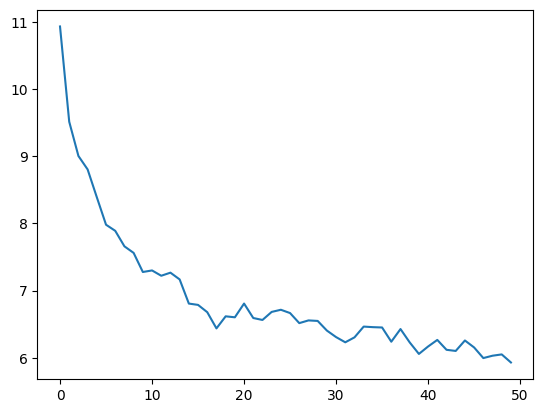

In [25]:
import matplotlib.pyplot as plt

plt.plot(losses)

In [26]:
torch.mps.empty_cache() #GPUPoor

evalText = text[1000:]
evalData = enc.encode(evalText)
B, maxT = 8, 512

x = torch.tensor(evalData[:B * maxT], device=computeDevice)
x = x.view(B, maxT)

# evalText = "Second Citizen:\nWould you proceed especially against Caius Marcius?"
# evalData = enc.encode(evalText)
# x = torch.tensor(evalData, device=computeDevice)
# x = x.view(1, -1)

with torch.no_grad():
    logits, loss = model(x)
    logits = logits[:,-1,:]
    probs = F.softmax(logits, dim=-1)
    # do top-k sampling of 50
    topk_probs, topk_indices = torch.topk(probs, 50, dim=-1)
    ix = torch.multinomial(topk_probs, 1) # (B,1)
    xcol = torch.gather(topk_indices, -1, ix)
    x = torch.cat((x, xcol), dim=1)

In [27]:
print(enc.decode(x[0,:-1].tolist()))
print("***" * 10)
for i in range(x.size(0)):
    print("--")
    print(enc.decode([x[i,-1].tolist()]))

Second Citizen:
Would you proceed especially against Caius Marcius?

All:
Against him first: he's a very dog to the commonalty.

Second Citizen:
Consider you what services he has done for his country?

First Citizen:
Very well; and could be content to give him good
report fort, but that he pays himself with being proud.

Second Citizen:
Nay, but speak not maliciously.

First Citizen:
I say unto you, what he hath done famously, he did
it to that end: though soft-conscienced men can be
content to say it was for his country he did it to
please his mother and to be partly proud; which he
is, even till the altitude of his virtue.

Second Citizen:
What he cannot help in his nature, you account a
vice in him. You must in no way say he is covetous.

First Citizen:
If I must not, I need not be barren of accusations;
he hath faults, with surplus, to tire in repetition.
What shouts are these? The other side o' the city
is risen: why stay we prating here? to the Capitol!

All:
Come, come.

First C